Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


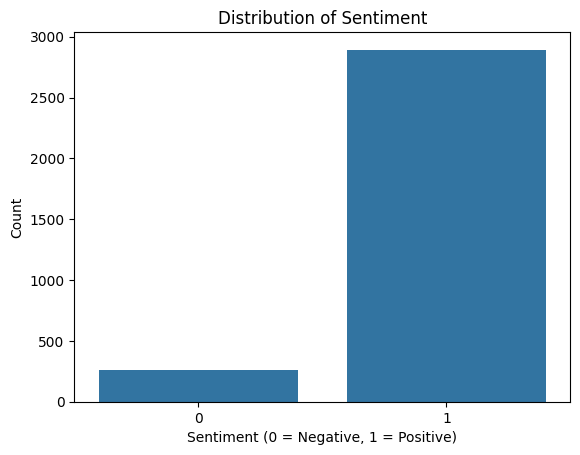

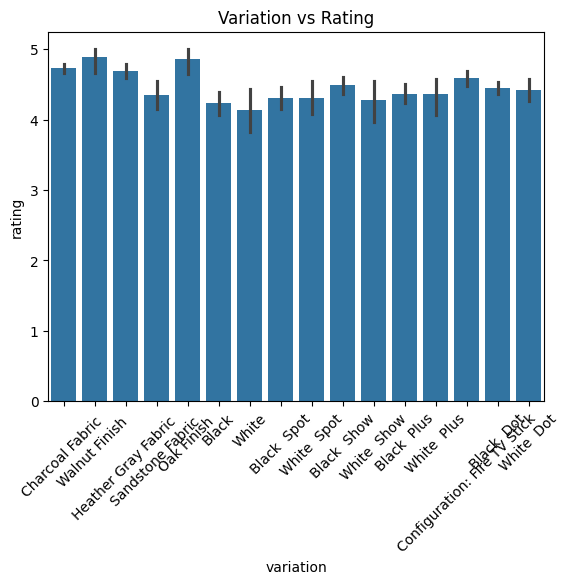

In [49]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/amazon_alexa.tsv'  # Update with your path
df = pd.read_csv(file_path, sep='\t')

# Handle missing values in text
df['verified_reviews'] = df['verified_reviews'].fillna("")

# Visualize distribution of sentiment classes
sns.countplot(data=df, x='feedback')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

# Visualize variation vs rating
sns.barplot(data=df, x='variation', y='rating')
plt.xticks(rotation=45)
plt.title('Variation vs Rating')
plt.show()

# Drop irrelevant columns
df.drop(['date', 'rating'], axis=1, inplace=True)

# One-hot encoding for categorical variable 'variation'
df = pd.get_dummies(df, columns=['variation'], drop_first=True)

# Vectorize review text
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df['verified_reviews'])

# Convert vectorized text to DataFrame
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

# Combine with original dataset (excluding text column)
df = df.drop(['verified_reviews'], axis=1)
df = pd.concat([df.reset_index(drop=True), X_text_df.reset_index(drop=True)], axis=1)

# Feature and target split
X = df.drop('feedback', axis=1)
y = df['feedback']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Bag of Words Shape: (3150, 1000)
TF-IDF Shape: (3150, 1000)
Vector shape for t-SNE: (293, 300)
Using t-SNE perplexity=30


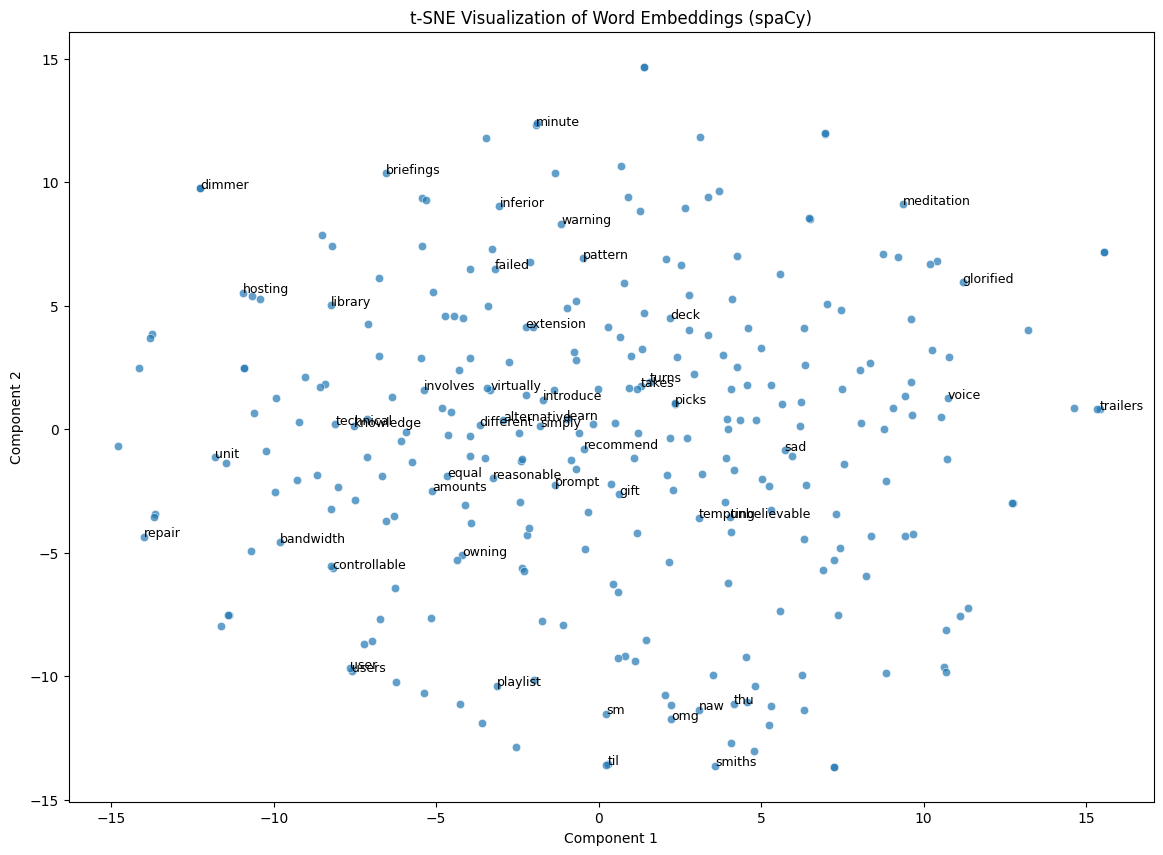

In [54]:
# Task 2: Feature Engineering for NLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
import spacy

# Reload original data with text and fill missing values
file_path = '/content/drive/MyDrive/amazon_alexa.tsv'  # Update your path here
df = pd.read_csv(file_path, sep='\t')
df['verified_reviews'] = df['verified_reviews'].fillna("")

# --- 1. Bag of Words (CountVectorizer)
bow_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_bow = bow_vectorizer.fit_transform(df['verified_reviews'])
print("Bag of Words Shape:", X_bow.shape)

# --- 2. TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['verified_reviews'])
print("TF-IDF Shape:", X_tfidf.shape)

# --- 3. Word Embedding using spaCy with en_core_web_lg model
nlp = spacy.load('en_core_web_lg')

# Tokenize reviews and filter tokens
review_tokens = df['verified_reviews'].apply(
    lambda x: [token for token in nlp(x.lower()) if token.is_alpha and not token.is_stop]
)

# Flatten tokens and get unique words
all_tokens = [token.text for tokens in review_tokens for token in tokens]
unique_tokens = list(set(all_tokens))

# Limit to 300 tokens for faster processing
unique_tokens = unique_tokens[:300]

vectors = []
labels = []

for word in unique_tokens:
    token = nlp.vocab[word]
    if token.has_vector:
        vectors.append(token.vector)
        labels.append(word)

vectors_np = np.array(vectors)
print("Vector shape for t-SNE:", vectors_np.shape)

# --- 4. t-SNE Visualization
# Ensure perplexity < number of samples
perplexity_value = min(30, vectors_np.shape[0] - 1)
print(f"Using t-SNE perplexity={perplexity_value}")

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
tsne_results = tsne.fit_transform(vectors_np)

# Plotting the t-SNE results
plt.figure(figsize=(14, 10))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], alpha=0.7)

# Annotate the first 50 words
for i, word in enumerate(labels[:50]):
    plt.annotate(word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings (spaCy)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [55]:
# Task 3: Text Classification Using Traditional Models
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reload dataset and fill missing reviews
file_path = '/content/drive/MyDrive/amazon_alexa.tsv'  # Update this path
df = pd.read_csv(file_path, sep='\t')
df['verified_reviews'] = df['verified_reviews'].fillna("")

# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['verified_reviews'])
y = df['feedback']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Define Logistic Regression model and hyperparameters grid
log_reg = LogisticRegression(max_iter=1000)
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Define Support Vector Classifier and hyperparameters grid
svc = SVC(probability=True)
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid search with 5-fold cross-validation for Logistic Regression
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='f1', n_jobs=-1)
log_reg_grid.fit(X_train, y_train)
print("Best Logistic Regression Params:", log_reg_grid.best_params_)

# Grid search with 5-fold cross-validation for SVC
svc_grid = GridSearchCV(svc, svc_params, cv=5, scoring='f1', n_jobs=-1)
svc_grid.fit(X_train, y_train)
print("Best SVC Params:", svc_grid.best_params_)

# Train best Logistic Regression model on full training set
best_log_reg = log_reg_grid.best_estimator_
best_log_reg.fit(X_train, y_train)

# Train best SVC model on full training set
best_svc = svc_grid.best_estimator_
best_svc.fit(X_train, y_train)

# Evaluate models on test set
y_pred_log_reg = best_log_reg.predict(X_test)
y_pred_svc = best_svc.predict(X_test)

print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_log_reg))

print("\nSupport Vector Machine Classification Report:\n")
print(classification_report(y_test, y_pred_svc))


Best Logistic Regression Params: {'C': 10, 'solver': 'liblinear'}
Best SVC Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.27      0.39        51
           1       0.94      0.99      0.96       579

    accuracy                           0.93       630
   macro avg       0.80      0.63      0.68       630
weighted avg       0.92      0.93      0.92       630


Support Vector Machine Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.31      0.46        51
           1       0.94      1.00      0.97       579

    accuracy                           0.94       630
   macro avg       0.92      0.66      0.72       630
weighted avg       0.94      0.94      0.93       630



In [56]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from datasets import load_metric
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and preprocess dataset ---
file_path = '/content/drive/MyDrive/amazon_alexa.tsv'  # update your path
df = pd.read_csv(file_path, sep='\t')
df['verified_reviews'] = df['verified_reviews'].fillna("")

# Split into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['verified_reviews'].tolist(),
    df['feedback'].tolist(),
    test_size=0.2,
    random_state=42
)

# --- Tokenization ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=128)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# --- Create torch Dataset ---
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# --- Load pre-trained BERT model ---
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# --- Optimizer and scheduler ---
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# --- Training loop ---
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))
model.train()

for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

# --- Evaluation ---
metric = load_metric("accuracy")
model.eval()

for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])

print("Validation accuracy:", metric.compute())

# --- Prediction example function ---
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs).item()
    return "Positive" if pred_label == 1 else "Negative"

# --- Examples
print(predict_sentiment("I love my Alexa device! It's so helpful."))
print(predict_sentiment("The device stopped working after a week."))


Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/474 [00:00<?, ?it/s]

KeyboardInterrupt: 